## COVID-19 country comparison

This generates a series of visualizations from the raw data tables, showing some aspects of the ongoing Covid-19 epidemic that I couldn't find in other reports.

Shared on Reddit [here](https://www.reddit.com/r/dataisbeautiful/comments/ff9jn4/oc_number_of_cases_per_country_counting_from_the/).

In [67]:
# Builtins
import datetime
import math
import requests
from io import StringIO

# Third party modules
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from IPython.display import display
import numpy as np
from scipy.optimize import curve_fit

register_matplotlib_converters()
matplotlib.rcParams['figure.figsize'] = (14, 8)        # Default size of all figures
cm = plt.cm.get_cmap('nipy_spectral')                  # This colormap is used for the colors of the plot lines

# Where to get the data
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
data_urls = {
    "confirmed": "time_series_19-covid-Confirmed.csv",
    "deaths":    "time_series_19-covid-Deaths.csv",
    "recovered": "time_series_19-covid-Recovered.csv"    
}

# Convenience function for labelling the y-axis
def set_y_axis_format(log=True):
    if log:
        plt.yscale("log")
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))

### Retrieve the latest version of the data and transform it into a set of Pandas dataframes

Show the first few rows of the confirmed cases dataframe for illustration.

In [68]:
# Set up a dictionary to store all the data in
dataframes = {}
for metric in data_urls.keys():
    url = base_url + data_urls[metric]                             # Combine URL parts
    r = requests.get(url)                                          # Retrieve from URL
    dataframes[metric] = pd.read_csv(StringIO(r.text), sep=",")    # Convert into Pandas dataframe
    
# Display the first 10 lines
display(dataframes["confirmed"].iloc[:10, :])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,410,410,411,413,414,414,418,418,422,426
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,102,119,120
5,Guangdong,Mainland China,23.3417,113.4244,26,32,53,78,111,151,...,1347,1348,1349,1349,1350,1350,1350,1351,1352,1352
6,Guangxi,Mainland China,23.8298,108.7881,2,5,23,23,36,46,...,252,252,252,252,252,252,252,252,252,252
7,Guizhou,Mainland China,26.8154,106.8748,1,3,3,4,5,7,...,146,146,146,146,146,146,146,146,146,146
8,Hainan,Mainland China,19.1959,109.7453,4,5,8,19,22,33,...,168,168,168,168,168,168,168,168,168,168
9,Hebei,Mainland China,38.0428,114.5149,1,1,2,8,13,18,...,317,318,318,318,318,318,318,318,318,318


### Process and add up all provinces/states into one row per country 

In [69]:
for metric in data_urls.keys():
    by_country = dataframes[metric].groupby("Country/Region").sum()                           # Group by country
    dates = by_country.columns[2:]                                            # Drop Lat/Long columns
    by_country.loc["All except China", dates] =\
        by_country.sum().loc[dates]-by_country.loc["Mainland China", dates]   # Add "Outside China" row
    by_country = by_country.loc[:, dates].astype(int)                         # Convert to columns to matplotlib dates
    dates = pd.to_datetime(dates)
    by_country.columns = dates

    if metric == "confirmed":
        # Add in some data points for China from before the start of the Johns Hopkins data.
        # Source: https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_coronavirus_outbreak_in_December_2019_%E2%80%93_January_2020
        early_china_data = {
            "1/17/20": 45,
            "1/18/20": 62,
            "1/20/20": 218
        }
        for d, n in early_china_data.items():
            by_country.loc["Mainland China", pd.to_datetime(d)] = n               # Insert early China data point
        by_country = by_country.reindex(list(sorted(by_country.columns)), axis=1) # Retain chronological column order

        # Correct an odd blip in the Japanese data. 
        # From 2/5 to 2/7, the Johns Hopkins data for Japan goes 22, 45, 25. 
        # I assume that the 45 is incorrect.
        by_country.loc["Japan", pd.to_datetime("2/06/20")] = 23.5      #  Halfway between values for 2/5 and 2/7
        
    dataframes[metric+"_by_country"] = by_country
    
confirmed_by_country = dataframes["confirmed_by_country"]              # Shorthand

with pd.option_context("display.max_rows", 200, "display.max_columns", 10):
    display(dataframes["confirmed_by_country"])

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07
Country/Region,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,0,0,...,1,1,1,1,1
Algeria,NaN,NaN,NaN,0,0,...,5,12,12,17,17
Andorra,NaN,NaN,NaN,0,0,...,1,1,1,1,1
Argentina,NaN,NaN,NaN,0,0,...,1,1,1,2,8
Armenia,NaN,NaN,NaN,0,0,...,1,1,1,1,1
Australia,NaN,NaN,NaN,0,0,...,39,52,55,60,63
Austria,NaN,NaN,NaN,0,0,...,21,29,41,55,79
Azerbaijan,NaN,NaN,NaN,0,0,...,3,3,6,6,9
Bahrain,NaN,NaN,NaN,0,0,...,49,52,55,60,85


### List all countries in the `by_country` table

In [70]:
for i, k in enumerate(confirmed_by_country.index):
    if len(k) > 15:
        k = k[:15] + "."
    print(f"{k:17}", end=" " if (i+1) % 5 else "\n")

Afghanistan       Algeria           Andorra           Argentina         Armenia          
Australia         Austria           Azerbaijan        Bahrain           Belarus          
Belgium           Bhutan            Bosnia and Herz.  Brazil            Cambodia         
Cameroon          Canada            Chile             Colombia          Costa Rica       
Croatia           Czech Republic    Denmark           Dominican Repub.  Ecuador          
Egypt             Estonia           Faroe Islands     Finland           France           
French Guiana     Georgia           Germany           Gibraltar         Greece           
Hong Kong         Hungary           Iceland           India             Indonesia        
Iran              Iraq              Ireland           Israel            Italy            
Japan             Jordan            Kuwait            Latvia            Lebanon          
Liechtenstein     Lithuania         Luxembourg        Macau             Mainland China   
Malaysia  

In [71]:
n_days_average = 5
min_cases = 40
short_metric_to_long = {
    "confirmed": "Confirmed cases",
    "deaths":    "Deaths",
    "active":    "Active cases",
    "growth_factor": f"{n_days_average}-day-average growth factor"
}

def plot(x_metric, y_metric, countries_to_plot, markers="o^v<>+xD*HP", colormap='nipy_spectral', use_log_scale=True):    
    length = None
    m = len(markers)
    cm = plt.cm.get_cmap(colormap)
    cNorm = matplotlib.colors.Normalize(vmin=0, vmax=len(countries_to_plot))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    if y_metric in dataframes:
        by_country   = dataframes[y_metric+"_by_country"]
    elif y_metric == "growth_factor":
        by_country   = dataframes["confirmed_by_country"]
    elif y_metric == "active":
        by_country = dataframes["confirmed_by_country"] - \
                     dataframes["deaths_by_country"] - \
                     dataframes["recovered_by_country"] 
    else:
        print(f"{y_metric}' is an invalid y_metric!")
        
    for i, country in enumerate(countries_to_plot):
        country_data = by_country.loc[country, dates]
        if y_metric == "growth_factor":
            if x_metric == "day_number":
                country_data = country_data[country_data >= min_cases]
            country_data = country_data.diff() / country_data + 1
            country_data = np.convolve(country_data, np.ones(n_days_average)/n_days_average, mode="valid")
        
        if x_metric == "calendar_date" and sum(pd.notnull(country_data)) > 0:
            plt.plot(country_data, markers[i%m]+"-", label=country, 
                 markersize=6, color=scalarMap.to_rgba(i))
        elif x_metric == "day_number":                   
            if y_metric != "growth_factor":
                country_data = country_data[country_data >= min_cases]
            if country == "Outside China":
                length = len(country_data)
            day_nr = list(range(len(country_data)))
            if sum(pd.notnull(country_data)) > 0:
                plt.plot(day_nr, country_data, markers[i%m]+"-", label=country, markersize=6, color=scalarMap.to_rgba(i))
      
    long_y_metric = short_metric_to_long[y_metric]
    plt.ylabel(long_y_metric, fontsize=14)
    if x_metric == "calendar_date":
        plt.xlabel("Date", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric} over time in selected countries", fontsize=16)
        plt.ylim(0.9, by_country.loc[countries_to_plot].max().max()*(2-0.9*(not use_log_scale)))
    elif x_metric == "day_number":
        plt.xlim(0, length)
        if y_metric in dataframes:
            plt.ylim(10-10*(not use_log_scale), by_country.loc[countries_to_plot].max().max()*(2-0.9*(not use_log_scale)))
        plt.xlabel("Day Number", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric}, from the first day with ≥{min_cases} local cases, in selected countries", 
                  fontsize=16)
        
    plt.legend()
    if y_metric == "growth_factor":
        plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.2f}"))
        plt.ylabel("Growth Factor", fontsize=14)
    else:
        set_y_axis_format(use_log_scale)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

### Plot cases over calendar date in selected countries

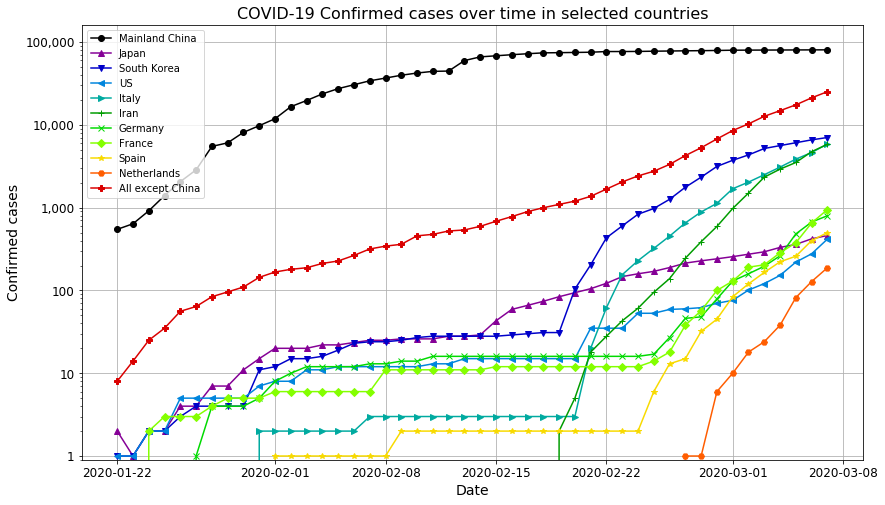

In [72]:
countries_to_plot = ["Mainland China", "Japan", "South Korea", "US", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "All except China"]
plot("calendar_date", "confirmed", countries_to_plot)

### Plot cases over days since start of local outbreak in selected countries

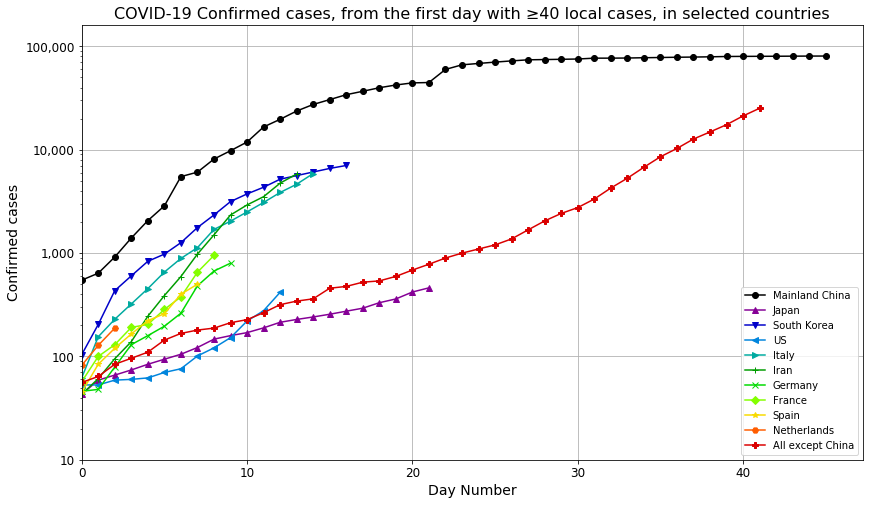

In [73]:
plot("day_number", "confirmed", countries_to_plot)

### Smoothed growth factor

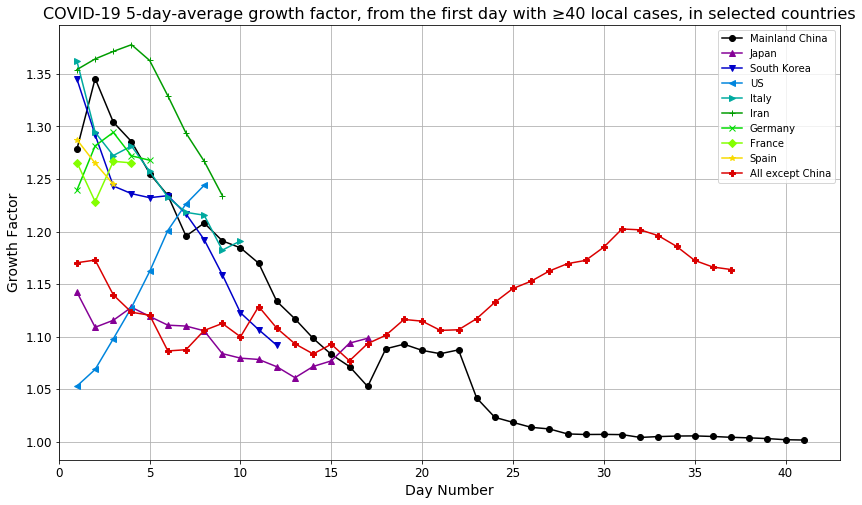

In [74]:
plot("day_number", "growth_factor", countries_to_plot)

### Confirmed cases, deaths and active cases in some other countries

This cell should be relatively easy to experiment in by changing the list of c

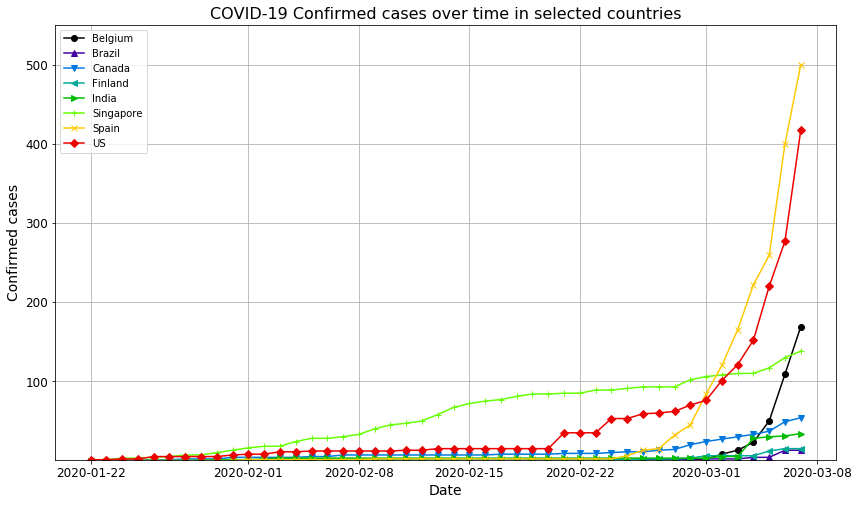

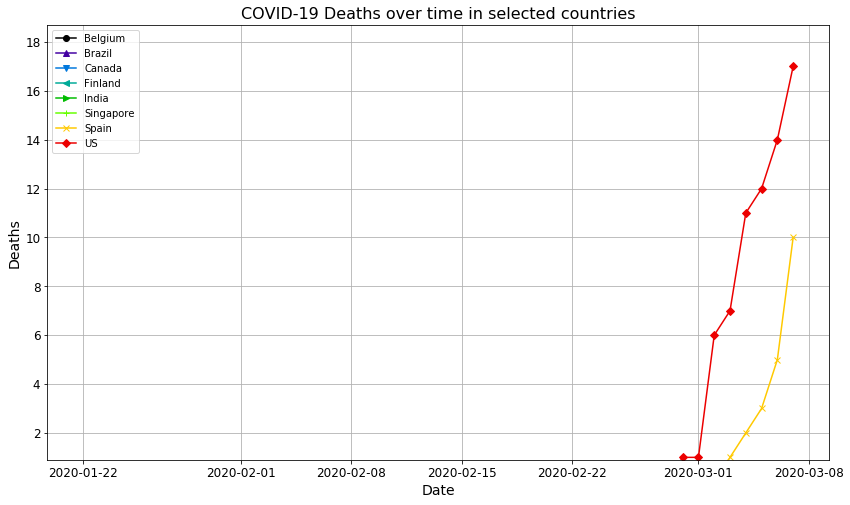

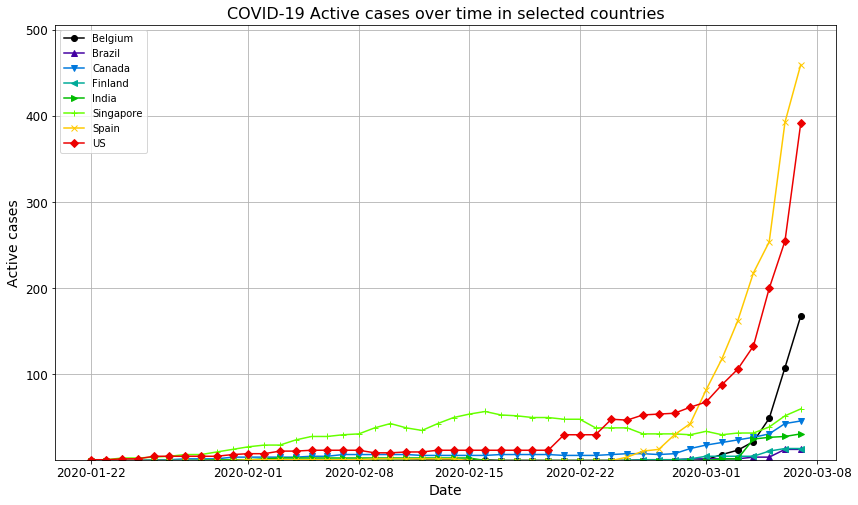

In [75]:
for y_metric in ["confirmed", "deaths", "active"]:
    plot("calendar_date", y_metric, 
         ["Belgium", "Brazil", "Canada", "Finland", "India", "Singapore", "Spain", "US"],
         use_log_scale=False)

### Fit a logistic curve and extrapolate number of future cases

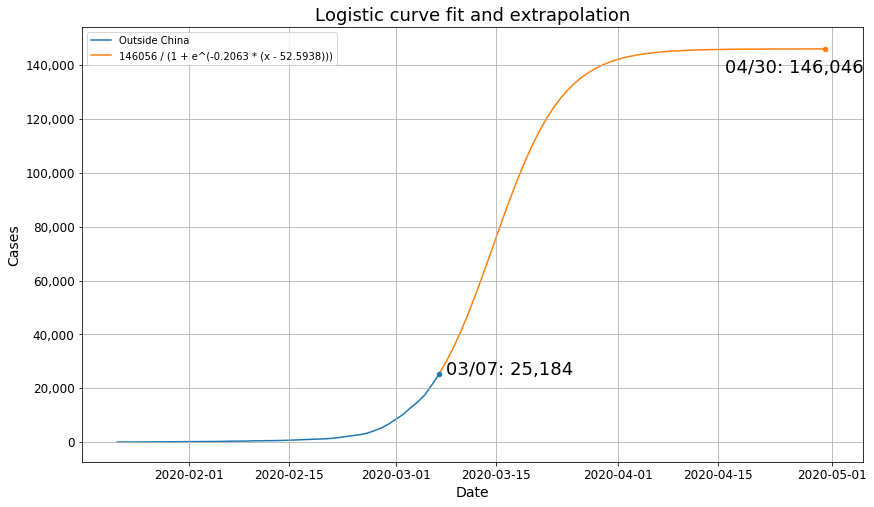

In [76]:
x = np.arange(100)
outside_china = dataframes["confirmed_by_country"].loc["All except China", :]
outside_china = outside_china[np.isfinite(outside_china)]
current_day = dates[-1]

def func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

[L, k, x0], _ =  curve_fit(func, np.arange(len(outside_china)), outside_china, p0=[1e7, 0.5, 65])

plt.plot(dates, outside_china, label="Outside China", markersize=3, zorder=1)

model_date_list = [current_day + datetime.timedelta(days = n+1) for n in range(-1, len(x) - len(dates))]
model_date_list = [mdates.date2num(x) for x in model_date_list]

n = len(dates)
logistic = L / (1 + np.exp(-k*(x[n-1:]-x0)))
plt.plot(model_date_list, logistic, label=f"{L:.0f} / (1 + e^(-{k:.4f} * (x - {x0:.4f})))", zorder=1)

plt.grid()
plt.legend()
plt.title("Logistic curve fit and extrapolation", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cases", fontsize=14)
plt.scatter(mdates.date2num(current_day), outside_china[-1], s=20, c="C00", zorder=2)
plt.annotate(f"{datetime.datetime.strftime(current_day, '%m/%d')}: {outside_china[-1]:,.0f}", 
             (mdates.date2num(current_day)+1, outside_china[-1]), fontsize=18)

plt.scatter(model_date_list[-1], logistic[-1], s=20, c="C01", zorder=2)
plt.annotate(f"{mdates.num2date(model_date_list[-1]).strftime('%m/%d')}: {logistic[-1]:,.0f}", 
             (model_date_list[-1]-14, logistic[-1]*0.94), fontsize=18)
set_y_axis_format(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()